In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
# ds = xr.open_dataset('./GEOSFP.20160701.A3dyn.4x5.nc').isel(time=0)
ds = xr.open_dataset('./GEOSFP.20160701.A3dyn.025x03125.nc').isel(time=0)

In [3]:
from pressure_level import get_reference_pressure
#ps = xr.open_dataset('./GEOSFP.20160701.I3.4x5.nc')['PS'].isel(time=0)
ps = xr.open_dataset('./GEOSFP.20160701.I3.025x03125.nc')['PS'].isel(time=0)

p_edge = get_reference_pressure(ps)
p_thick = p_edge[:-1] - p_edge[1:]

p_edge_ref = get_reference_pressure()
p_thick_ref = p_edge_ref[:-1] - p_edge_ref[1:]

In [4]:
#u_true = ds['U'].isel(lev=20).values
#v_true = ds['V'].isel(lev=20).values

u_true = np.sum(ds['U'].values*p_thick, axis=0) / np.sum(p_thick_ref)
v_true = np.sum(ds['V'].values*p_thick, axis=0) / np.sum(p_thick_ref)

In [5]:
# grid size for computing spatial derivative

# 4x5 resolution
# dlat, dlon = 4.0, 5.0
# lat = np.clip(ds['lat'].values, -88, 88)
dlat, dlon = 0.25, 0.3125
lat = ds['lat'].values

dy = 110.574e3 * dlat # degree lat -> meter
dx_all = 111.320e3 * np.cos(lat/180*np.pi) * dlon # degree lon -> meter
dx = dx_all.max()  # normal to equator

dx.shape, dx, dy

((), 34787.5, 27643.5)

In [6]:
u = u_true / dx_all[:,np.newaxis] * dx
v = v_true

In [7]:
# spatial derivative
# axis number assumes 2D array
dudx = (np.roll(u,-1,axis=1)-np.roll(u,1,axis=1))/(2*dx)
dvdy = (np.roll(v,-1,axis=0)-np.roll(v,1,axis=0))/(2*dy)
div = dudx + dvdy

Text(0.5,1,'normalized U')

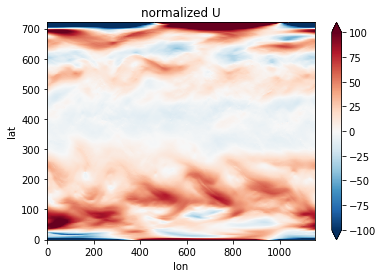

In [8]:
xr.DataArray(u, dims=['lat', 'lon']).plot(vmin=-100, vmax=100, cmap='RdBu_r')
plt.title('normalized U')

Text(0.5,1,'divergence (1/s)')

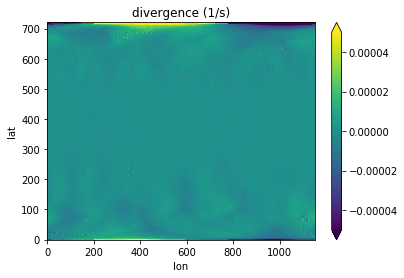

In [9]:
xr.DataArray(div, dims=['lat', 'lon']).plot(vmin=-5e-5, vmax=5e-5)
plt.title('divergence (1/s)')

# Solve plume transport

In [10]:
from advection_solver.advection_2d import tendency_2d_vanleer, tendency_2d_upwind

In [11]:
u.shape

(721, 1152)

In [12]:
ny, nx = u.shape
dt = 5*60 # seconds

c0 = np.zeros([ny, nx])
c0[int(ny*0.6):int(ny*0.7), int(nx*0.1):int(nx*0.2)] = 1.0  # 2D square

In [13]:
# CFL
u.max()*dt/dx, v.max()*dt/dy

(53.70554080627069, 0.33149272684984993)

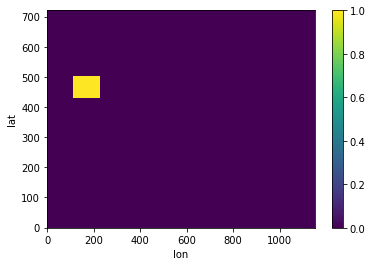

In [14]:
xr.DataArray(c0, dims=['lat', 'lon']).plot()

In [15]:
%%time
nt = 1 * 24 * 3600//dt 

c = c0.copy()
for _ in range(nt):
    c += tendency_2d_vanleer(c, u, v, dx, dy, dt)

CPU times: user 49.1 s, sys: 1.75 s, total: 50.9 s
Wall time: 28.8 s


In [16]:
# creates overshoot because the wind is not entirely divergence-free
c.max(), c.min()

(1.2621177722852297, -0.0006915281183194022)

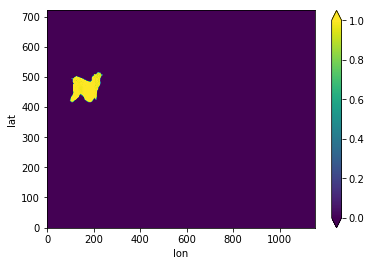

In [17]:
xr.DataArray(c, dims=['lat', 'lon']).plot(vmax=1, vmin=0)

# Use spherical harmonics

In [18]:
from windspharm.xarray import VectorWind

In [19]:
ds = ds.isel(lev=20)

In [20]:
ds['lat'].values = np.linspace(-90, 90, ds['lat'].size)
ds['lat']

<xarray.DataArray 'lat' (lat: 721)>
array([-90.  , -89.75, -89.5 , ...,  89.5 ,  89.75,  90.  ])
Coordinates:
    time     datetime64[ns] 2016-07-01T01:30:00
    lev      float32 21.0
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
Attributes:
    long_name:  latitude
    units:      degrees_north

In [21]:
%%time
# construct windspharm object
wind = VectorWind(ds['U'], ds['V'])

CPU times: user 4.49 s, sys: 559 ms, total: 5.05 s
Wall time: 4.86 s


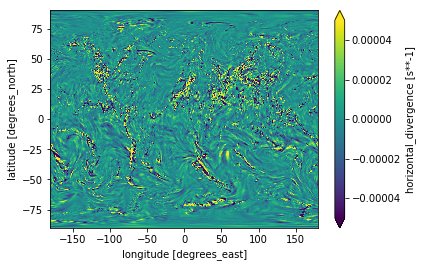

In [22]:
wind.divergence().plot(vmin=-5e-5, vmax=5e-5)

In [23]:
u_psi, v_psi = wind.nondivergentcomponent()
u_true = u_psi.values
v_true = v_psi.values

In [24]:
u = u_true / dx_all[:,np.newaxis] * dx
v = v_true

In [25]:
# spatial derivative
# axis number assumes 2D array
dudx = (np.roll(u,-1,axis=1)-np.roll(u,1,axis=1))/(2*dx)
dvdy = (np.roll(v,-1,axis=0)-np.roll(v,1,axis=0))/(2*dy)
div = dudx + dvdy

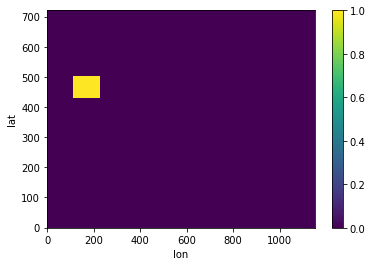

In [26]:
xr.DataArray(c0, dims=['lat', 'lon']).plot()

In [27]:
%%time
nt = 1 * 24 * 3600//dt 

c = c0.copy()
for _ in range(nt):
    c += tendency_2d_vanleer(c, u, v, dx, dy, dt)

CPU times: user 46.2 s, sys: 2.58 s, total: 48.8 s
Wall time: 28.6 s


In [28]:
# Even worse!!
c.max(), c.min()

(63.560548168477126, -0.015908667005739507)

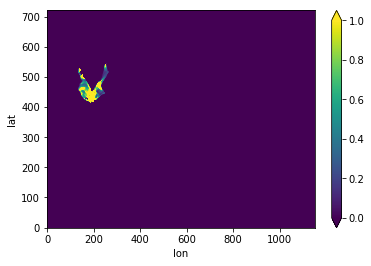

In [29]:
xr.DataArray(c, dims=['lat', 'lon']).plot(vmax=1, vmin=0)